# PV model at 5 km horizontal resolution
PV model (gsee) from Renewables Ninja and radiation data from SARAH-3 </br>
Linh Ho - 2024.11.26

### Read SARAH-3 data for NL
Data and document in https://wui.cmsaf.eu/safira/action/viewDoiDetails?acronym=SARAH_V003

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

os.chdir('/home/linhho/Documents/My_research/Microgrids/gsee')
import gsee
%pip install -e .

Obtaining file:///home/linhho/Documents/My_research/Microgrids/gsee
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for gsee (pyproject.toml) ... done
  Created wheel for gsee: filename=gsee-0.4.0.dev0-0.editable-py3-none-any.whl size=3632 sha256=107e4583a38e638fba3b154073c069cc9eae38a6903d4ac59391c696d0604c71
  Stored in directory: /tmp/pip-ephem-wheel-cache-844dsro9/wheels/a1/73/59/2df8a2e335e20a7d42bf35210f4adc8d897b0dece7faf1b56b
Successfully built gsee
  Attempting uninstall: gsee
    Found existing installation: gsee 0.4.0.dev0
    Uninstalling gsee-0.4.0.dev0:
      Successfully uninstalled gsee-0.4.0.dev0
Note: you may need to restart the kernel to use updated packages.


Available variables from SARAH-3 (5 km horizontal resolution) </br>
- Daylight (DAL)
- Direct Normalised Irradiance (DNI)
- Effective cloud albedo (CAL)
- Photosynthetic Active Radiation (PAR)
- Sunshine Duration (SDU)
- Surface incoming direct radiation (SID)
- Surface incoming shortwave radiation (SIS)


In [14]:
# read SARAH-3 data for Europe Surface incoming shortwave radiation (SIS) instantaneous
data = xr.open_dataset("../data/SISin202101010000004UD10001I1UD.nc")
data

<xarray.Dataset>
Dimensions:        (time: 48, lon: 2171, bnds: 2, lat: 856)
Coordinates:
  * time           (time) datetime64[ns] 2021-01-01 ... 2021-01-01T23:30:00
  * lon            (lon) float32 -44.12 -44.08 -44.03 ... 64.28 64.32 64.38
  * lat            (lat) float32 22.23 22.27 22.33 22.38 ... 64.88 64.93 64.97
Dimensions without coordinates: bnds
Data variables:
    lon_bnds       (lon, bnds) float32 ...
    lat_bnds       (lat, bnds) float32 ...
    SIS            (time, lat, lon) float32 ...
    record_status  (time) int8 ...
Attributes: (12/41)
    CDI:                        Climate Data Interface version 2.4.0 (https:/...
    Conventions:                CF-1.7,ACDD-1.3
    institution:                EUMETSAT/CMSAF
    title:                      CM SAF Surface Solar Radiation Climate Data R...
    summary:                    This file contains data from the CM SAF Surfa...
    id:                         DOI:10.5676/EUM_SAF_CM/SARAH/V003
    ...                         ...
    instrument_vocabulary:      GCMD Instruments, Version 8.6
    instrument:                 SEVIRI > Spinning Enhanced Visible and Infrar...
    variable_id:                SIS
    license:                    The CM SAF data are owned by EUMETSAT and are...
    history:                    Wed Nov 13 00:29:45 2024: cdo -v -L -f nc4 -z...
    CDO:                        Climate Data Operators version 2.4.0 (https:/...

### Use a country mask to get only data for NL

In [96]:
# OLD - create a mask from shapefile
# Adapt to find column with specific coordinates???
# TU Delft 52.0022° N, 4.3736° E
import geopandas as gpd

cnt = "NL"

# Read in NETCDF as a pandas dataframe
# Xarray provides a simple method of opening netCDF files, and converting them to pandas dataframes
fname = "../data/SISin202101010000004UD10001I1UD.nc"
ds = xr.open_dataset(fname).isel(time=slice(24, 25)).to_dataframe().reset_index()

# Read shapefile using gpd.read_file()
polys = gpd.read_file("../shapefile/CNTR_RG_01M_2020_4326/CNTR_RG_01M_2020_4326.shp")
cntrs = polys.set_index("CNTR_ID")["geometry"][cnt]

# use geopandas points_from_xy() to transform Longitude and Latitude into a list of shapely
# Point objects and set it as a geometry while creating the GeoDataFrame
ds_gdf = gpd.GeoDataFrame(ds, geometry=gpd.points_from_xy(ds.lon, ds.lat))

# set coordinates equal to each other
# PointsGeodataframe.crs = PolygonsGeodataframe.crs
ds_gdf.crs = polys.crs

# Clip points, lines, or polygon geometries to the mask extent.
mask_cnt = gpd.clip(ds_gdf, cntrs)
mask.plot()

# Plot point on map
# https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
gdf = GeoDataFrame(df, geometry=geometry)

# this is a simple map that goes with geopandas
# deprecated: world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file(geodatasets.data.naturalearth.land["url"])
gdf.plot(ax=world.plot(figsize=(10, 6)), marker="o", color="red", markersize=15)

,time,lon,bnds,lat,lon_bnds,lat_bnds,SIS,record_status,geometry
1643244,2021-01-01 12:00:00,3.825,1,51.224998,3.85,51.250000,238.0,0,POINT (3.825 51.225)
1642388,2021-01-01 12:00:00,3.825,0,51.224998,3.80,51.200001,238.0,0,POINT (3.825 51.225)
1644100,2021-01-01 12:00:00,3.875,0,51.224998,3.85,51.200001,237.0,0,POINT (3.875 51.225)
1644956,2021-01-01 12:00:00,3.875,1,51.224998,3.90,51.250000,237.0,0,POINT (3.875 51.225)
1638965,2021-01-01 12:00:00,3.725,0,51.275002,3.70,51.250000,251.0,0,POINT (3.725 51.275)
...,...,...,...,...,...,...,...,...,...
1733170,2021-01-01 12:00:00,6.475,0,53.525002,6.45,53.500000,96.0,0,POINT (6.475 53.525)
1697216,2021-01-01 12:00:00,5.425,0,53.424999,5.40,53.400002,100.0,0,POINT (5.425 53.425)
1698928,2021-01-01 12:00:00,5.475,0,53.424999,5.45,53.400002,122.0,0,POINT (5.475 53.425)
1699784,2021-01-01 12:00:00,5.475,1,53.424999,5.50,53.450001,122.0,0,POINT (5.475 53.425)


New way, use regionmask to mask country data directly from natural earth

In [8]:
import regionmask

fname = "../data/SISin202101010000004UD10001I1UD.nc"
ds = xr.open_dataset(fname).isel(time=slice(18, 24))  # .to_dataframe().reset_index()

mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(ds)
# Check key of the selected country
mask_key = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(
    "Netherlands"
)
ds_cnt = ds.where(mask == mask_key)
ds_cnt

<xarray.Dataset>
Dimensions:        (lon: 2171, bnds: 2, lat: 856, time: 6)
Coordinates:
  * time           (time) datetime64[ns] 2021-01-01T09:00:00 ... 2021-01-01T1...
  * lon            (lon) float32 -44.12 -44.08 -44.03 ... 64.28 64.32 64.38
  * lat            (lat) float32 22.23 22.27 22.33 22.38 ... 64.88 64.93 64.97
Dimensions without coordinates: bnds
Data variables:
    lon_bnds       (lon, bnds, lat) float32 nan nan nan nan ... nan nan nan nan
    lat_bnds       (lat, bnds, lon) float32 nan nan nan nan ... nan nan nan nan
    SIS            (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    record_status  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/41)
    CDI:                        Climate Data Interface version 2.4.0 (https:/...
    Conventions:                CF-1.7,ACDD-1.3
    institution:                EUMETSAT/CMSAF
    title:                      CM SAF Surface Solar Radiation Climate Data R...
    summary:                    This file contains data from the CM SAF Surfa...
    id:                         DOI:10.5676/EUM_SAF_CM/SARAH/V003
    ...                         ...
    instrument_vocabulary:      GCMD Instruments, Version 8.6
    instrument:                 SEVIRI > Spinning Enhanced Visible and Infrar...
    variable_id:                SIS
    license:                    The CM SAF data are owned by EUMETSAT and are...
    history:                    Wed Nov 13 00:29:45 2024: cdo -v -L -f nc4 -z...
    CDO:                        Climate Data Operators version 2.4.0 (https:/...

In [5]:
regionmask.defined_regions.natural_earth_v5_0_0.countries_110

<regionmask.Regions 'Natural Earth Countries: 110m'>
Source:   http://www.naturalearthdata.com
overlap:  False

Regions:
  0 FJ                     Fiji
  1 TZ                 Tanzania
  2 WS                W. Sahara
  3 CA                   Canada
  4 US United States of America
 .. ..                      ...
172 RS                   Serbia
173 ME               Montenegro
174 KO                   Kosovo
175 TT      Trinidad and Tobago
176 SS                 S. Sudan

[177 regions]

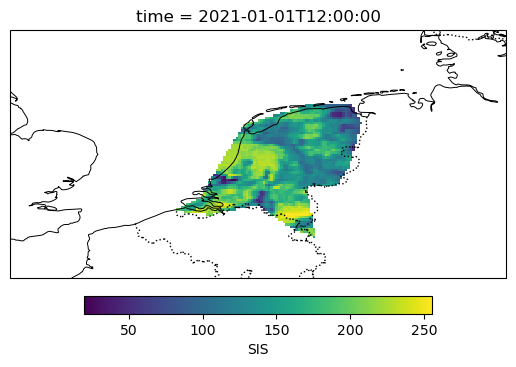

In [4]:
import cartopy
import cartopy.crs as ccrs

# my_cmap = plt.get_cmap('YlOrBr', 10)
# colorbar_range = [0, 1000]

to_plot = ds_cnt["SIS"]

ax = plt.subplot(111, projection=ccrs.PlateCarree())

h = to_plot.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines(alpha=1, linewidth=0.7)
ax.add_feature(cartopy.feature.BORDERS, alpha=1, linestyle=":")

# fine tune the extent
ax.set_extent([0, 10, 50, 55], crs=ccrs.PlateCarree())

cbar = plt.colorbar(h, orientation="horizontal", fraction=0.075, pad=0.05, shrink=0.7)
cbar.set_label("SIS")

### Input gsee with xarray (long, lat, time)

In [2]:
import regionmask

# mask data in one dataset include
# direct horizontal, diffuse horizontal, temperature
# with time, lon, lat coordinates

ds = xr.open_dataset("../data/SIDin202101010000004UD10001I1UD.nc").isel(
    time=slice(18, 24)
)

# get the mask for selected country
mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(ds)
mask_key = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(
    "Netherlands"
)

ds = ds.where(mask == mask_key).rename(name_dict={"SID": "direct_horizontal"})

tmp = xr.open_dataset("../data/SISin202101010000004UD10001I1UD.nc").isel(
    time=slice(18, 24)
)
tmp = tmp.where(mask == mask_key)
ds["diffuse_horizontal"] = tmp["SIS"] - ds["direct_horizontal"]
_t2m = pd.read_csv(
    "../data/renewables_ninja/renewables_ninja_country_NL_temperature_merra-2_land-wtd.csv",
    comment="#",
    sep=",",
    parse_dates=True,
).set_index("time")["NL33"]
# select only the same time period
_t2m.index = pd.to_datetime(_t2m.index)
a = _t2m.resample("30min").interpolate().loc[ds["time"].data].tolist()
ds["temperature"] = xr.DataArray(
    data=np.transpose(np.array([np.array([a] * 2171)] * 856), (2, 0, 1)),
    dims=("time", "lat", "lon"),
)
ds["temperature"] = ds["temperature"].where(mask == mask_key)
ds

<xarray.Dataset>
Dimensions:             (time: 6, lon: 2171, lat: 856, bnds: 2)
Coordinates:
  * time                (time) datetime64[ns] 2021-01-01T09:00:00 ... 2021-01...
  * lon                 (lon) float32 -44.12 -44.08 -44.03 ... 64.28 64.32 64.38
  * lat                 (lat) float32 22.23 22.27 22.33 ... 64.88 64.93 64.97
Dimensions without coordinates: bnds
Data variables:
    lon_bnds            (lon, bnds, lat) float32 nan nan nan nan ... nan nan nan
    lat_bnds            (lat, bnds, lon) float32 nan nan nan nan ... nan nan nan
    direct_horizontal   (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    record_status       (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    diffuse_horizontal  (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    temperature         (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes: (12/41)
    CDI:                        Climate Data Interface version 2.4.0 (https:/...
    Conventions:                CF-1.7,ACDD-1.3
    institution:                EUMETSAT/CMSAF
    title:                      CM SAF Surface Solar Radiation Climate Data R...
    summary:                    This file contains data from the CM SAF Surfa...
    id:                         DOI:10.5676/EUM_SAF_CM/SARAH/V003
    ...                         ...
    instrument_vocabulary:      GCMD Instruments, Version 8.6
    instrument:                 SEVIRI > Spinning Enhanced Visible and Infrar...
    variable_id:                SID
    license:                    The CM SAF data are owned by EUMETSAT and are...
    history:                    Thu Nov 28 11:14:28 2024: cdo -v -L -f nc4 -z...
    CDO:                        Climate Data Operators version 2.4.0 (https:/...

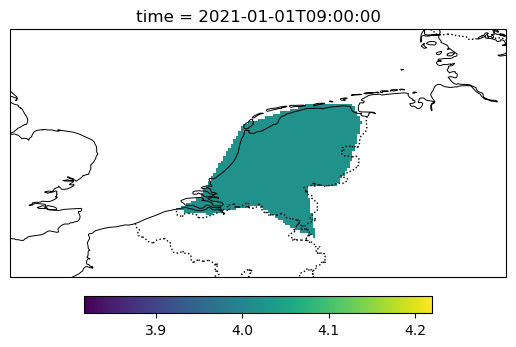

In [4]:
import cartopy
import cartopy.crs as ccrs

# my_cmap = plt.get_cmap('YlOrBr', 10)
# colorbar_range = [0, 1000]

to_plot = ds["temperature"][0, :, :]

ax = plt.subplot(111, projection=ccrs.PlateCarree())

h = to_plot.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines(alpha=1, linewidth=0.7)
ax.add_feature(cartopy.feature.BORDERS, alpha=1, linestyle=":")

# fine tune the extent
ax.set_extent([0, 10, 50, 55], crs=ccrs.PlateCarree())

cbar = plt.colorbar(h, orientation="horizontal", fraction=0.075, pad=0.05, shrink=0.7)

In [11]:
pd.to_datetime(ds.time)

DatetimeIndex(['2021-01-01 09:00:00', '2021-01-01 09:30:00',
               '2021-01-01 10:00:00', '2021-01-01 10:30:00',
               '2021-01-01 11:00:00', '2021-01-01 11:30:00'],
              dtype='datetime64[ns]', freq=None)

In [3]:
result = gsee.pv.run_model(
    ds,
    # coords=coords,  # Latitude and longitude
    tilt=30,  # 30 degrees tilt angle
    azim=180,  # facing towards equator,
    tracking=0,  # fixed - no tracking
    capacity=1,  # 1000 W
)
result

darray.direct_horizontal.data (6, 856, 2171), angles (6,)


ValueError: operands could not be broadcast together with shapes (6,856,2171) (6,) 

### Select one point to test gsee (TU Delft)

In [2]:
fname = "../data/SISin202101010000004UD10001I1UD.nc"
ds = xr.open_dataset(fname)

ds_point = ds["SIS"].sel(lon=4.7, lat=52, method="nearest")
ds_point

<xarray.DataArray 'SIS' (time: 48)>
array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   8.,  34.,  60.,  95., 184., 162., 215., 169.,
       151., 183., 179., 150.,  66.,  53.,   3.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2021-01-01T23:30:00
    lon      float32 4.675
    lat      float32 52.03
Attributes:
    standard_name:  surface_downwelling_shortwave_flux_in_air
    long_name:      Surface Downwelling Shortwave Radiation
    units:          W m-2
    cell_methods:   time: point

Get temperature data from Renewables ninja. The same time series for NUTS2. Delft in the regional code NL33
- Land weighted vs population weighted?
- Later: get temperature from ERA5 by matching the grid box?

In [3]:
# still need to slice a subset of this matched with the selected period
fname = "../data/renewables_ninja/renewables_ninja_country_NL_temperature_merra-2_land-wtd.csv"
_t2m = pd.read_csv(fname, comment="#", sep=",", parse_dates=True).set_index("time")[
    "NL33"
]
_t2m

time
1980-01-01 00:00:00     3.013
1980-01-01 01:00:00     2.901
1980-01-01 02:00:00     2.767
1980-01-01 03:00:00     2.568
1980-01-01 04:00:00     2.435
                        ...  
2022-12-31 19:00:00    12.590
2022-12-31 20:00:00    12.360
2022-12-31 21:00:00    12.188
2022-12-31 22:00:00    12.127
2022-12-31 23:00:00    11.989
Name: NL33, Length: 376944, dtype: float64

In [5]:
""" Prepare input dataframe for gsee

Parameters
----------
sis : path to data Surface incoming shortwave radiation, instantaneous (Wm-2)
sid : path to data Surface incoming direct radiation, instantaneous (Wm-2)
t2m : path to data temperature (C) at 2 m

Returns
----------
pandas.DataFrame with columns:
- direct surface (horizontal) irradiance (in W/m2)
- diffuse irradiance (in W/m2)
- temperature (in degrees Celsius)

"""


def prepare(sis, sid, t2m, sel_lat, sel_lon):
    _sis = xr.open_dataset(sis)["SIS"].sel(lon=sel_lon, lat=sel_lat, method="nearest")
    _sid = xr.open_dataset(sid)["SID"].sel(lon=sel_lon, lat=sel_lat, method="nearest")
    _t2m = pd.read_csv(t2m, comment="#", sep=",", parse_dates=True).set_index("time")[
        "NL33"
    ]

    # select only the same time period
    _t2m.index = pd.to_datetime(_t2m.index)
    _t2m = _t2m.resample("30min").interpolate().loc[_sis["time"].data]

    return pd.DataFrame(
        data={
            "time": _t2m.index,
            "direct_horizontal": _sid.data,
            "diffuse_horizontal": (_sis - _sid).data,
            # "global_horizontal": _sis.data,
            "temperature": _t2m.tolist(),
        }
    )

In [6]:
df = prepare(
    sis="../data/SISin202101010000004UD10001I1UD.nc",
    sid="../data/SIDin202101010000004UD10001I1UD.nc",
    t2m="../data/renewables_ninja/renewables_ninja_country_NL_temperature_merra-2_land-wtd.csv",
    sel_lat=52,
    sel_lon=4.7,
)
# df["diffuse_fraction"] = 1 - df["direct_horizontal"] / df["global_horizontal"]
df = df.set_index("time")  # temporarily
df

,direct_horizontal,diffuse_horizontal,temperature
time,,,
2021-01-01 00:00:00,0.0,0.0,1.4050
2021-01-01 00:30:00,0.0,0.0,1.4120
2021-01-01 01:00:00,0.0,0.0,1.4190
2021-01-01 01:30:00,0.0,0.0,1.5105
2021-01-01 02:00:00,0.0,0.0,1.6020
2021-01-01 02:30:00,0.0,0.0,1.7170
2021-01-01 03:00:00,0.0,0.0,1.8320
2021-01-01 03:30:00,0.0,0.0,1.9095
2021-01-01 04:00:00,0.0,0.0,1.9870


## gsee

In [7]:
coords = (52.0, 4.7)

result = gsee.pv.run_model(
    df,
    coords=coords,  # Latitude and longitude
    tilt=30,  # 30 degrees tilt angle
    azim=180,  # facing towards equator,
    tracking=0,  # fixed - no tracking
    capacity=1,  # 1000 W
)
result

time
2021-01-01 00:00:00    0.000000
2021-01-01 00:30:00    0.000000
2021-01-01 01:00:00    0.000000
2021-01-01 01:30:00    0.000000
2021-01-01 02:00:00    0.000000
2021-01-01 02:30:00    0.000000
2021-01-01 03:00:00    0.000000
2021-01-01 03:30:00    0.000000
2021-01-01 04:00:00    0.000000
2021-01-01 04:30:00    0.000000
2021-01-01 05:00:00    0.000000
2021-01-01 05:30:00    0.000000
2021-01-01 06:00:00    0.000000
2021-01-01 06:30:00    0.000000
2021-01-01 07:00:00    0.000000
2021-01-01 07:30:00    0.000000
2021-01-01 08:00:00    0.000000
2021-01-01 08:30:00    0.028040
2021-01-01 09:00:00    0.054920
2021-01-01 09:30:00    0.107533
2021-01-01 10:00:00    0.382851
2021-01-01 10:30:00    0.235833
2021-01-01 11:00:00    0.404412
2021-01-01 11:30:00    0.227211
2021-01-01 12:00:00    0.180818
2021-01-01 12:30:00    0.309801
2021-01-01 13:00:00    0.364617
2021-01-01 13:30:00    0.337638
2021-01-01 14:00:00    0.068691
2021-01-01 14:30:00    0.113268
2021-01-01 15:00:00    0.000000
202

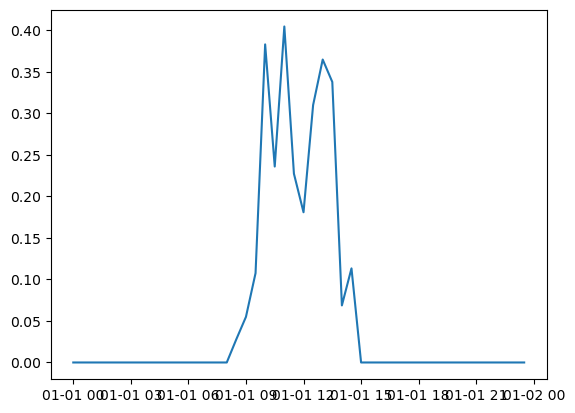

In [8]:
result.to_csv("../data/result_original_diffuse_ratio_20210101.csv", sep=",")
plt.plot(result)

### gsee without diffuse_fraction

In [7]:
coords = (52.0, 4.7)

result = gsee.pv.run_model(
    df,
    coords=coords,  # Latitude and longitude
    tilt=30,  # 30 degrees tilt angle
    azim=180,  # facing towards equator,
    tracking=0,  # fixed - no tracking
    capacity=1,  # 1000 W
)
result

time
2021-01-01 00:00:00    0.000000
2021-01-01 00:30:00    0.000000
2021-01-01 01:00:00    0.000000
2021-01-01 01:30:00    0.000000
2021-01-01 02:00:00    0.000000
2021-01-01 02:30:00    0.000000
2021-01-01 03:00:00    0.000000
2021-01-01 03:30:00    0.000000
2021-01-01 04:00:00    0.000000
2021-01-01 04:30:00    0.000000
2021-01-01 05:00:00    0.000000
2021-01-01 05:30:00    0.000000
2021-01-01 06:00:00    0.000000
2021-01-01 06:30:00    0.000000
2021-01-01 07:00:00    0.000000
2021-01-01 07:30:00    0.000000
2021-01-01 08:00:00    0.000000
2021-01-01 08:30:00    0.028040
2021-01-01 09:00:00    0.054920
2021-01-01 09:30:00    0.107533
2021-01-01 10:00:00    0.382851
2021-01-01 10:30:00    0.235833
2021-01-01 11:00:00    0.404412
2021-01-01 11:30:00    0.227211
2021-01-01 12:00:00    0.180818
2021-01-01 12:30:00    0.309801
2021-01-01 13:00:00    0.364617
2021-01-01 13:30:00    0.337638
2021-01-01 14:00:00    0.068691
2021-01-01 14:30:00    0.113268
2021-01-01 15:00:00    0.000000
202

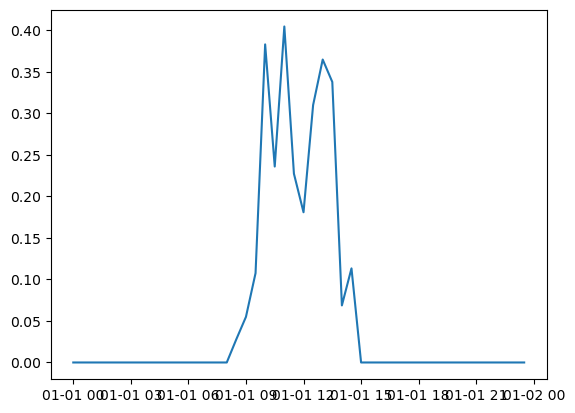

In [8]:
plt.plot(result)

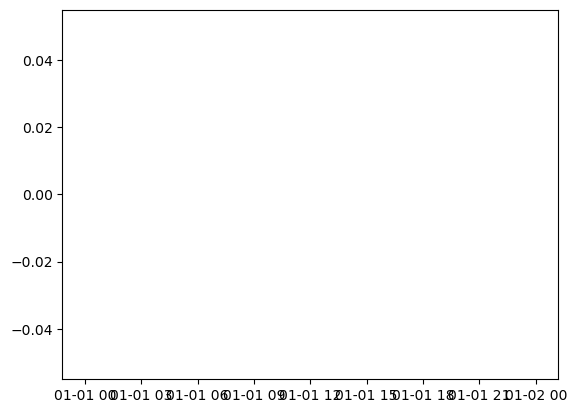

In [22]:
df_test = pd.read_csv(
    "../data/result_original_diffuse_fraction_20210101.csv", sep=",", parse_dates=True
).set_index("time")
plt.plot(df_test["0"] - result)

In [23]:
result.equals(df_test["0"])

False

In [24]:
df_test["0"].equals(result)

False

In [25]:
sum(df_test["0"] - result)

nan

In [26]:
sum(df_test["0"])

2.815634520058941

In [27]:
sum(result)

2.8156345708496313

In [ ]:
small difference at 10e-8